In [23]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.cm as cm
import matplotlib.patches as mpatches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
era_wbgt = xr.open_mfdataset('/local/ss23/ERA5/era5_daily_mean_WBGT*',concat_dim='time',combine='by_coords')
era_wbgt = era_wbgt.where(era_wbgt>25,25)
era_wbgt = era_wbgt.where(era_wbgt<33,33)

In [13]:
# Convert from WBGT to capacity
era_cap_daily = 100 - 25*((era_wbgt-25)**(2/3))

# Go from daily capacity to monthly capacity
era_cap_monthly = era_cap_daily.resample(time='1M').mean()

In [17]:
era_cap_monthly = era_cap_monthly.rename({'WBGT':'capacity'})

In [19]:
# Slice 1980-2000 data
ds = era_cap_monthly
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_mean = ds_hist.mean('year')
ds_hist_dev = ds_hist.std('year')

# Return baseline as the lower bound of "envelope" around mean 
ds_base = ds_hist_mean - 2*ds_hist_dev

In [25]:
ds_base = ds_base.rename({'longitude':'lon','latitude':'lat'})

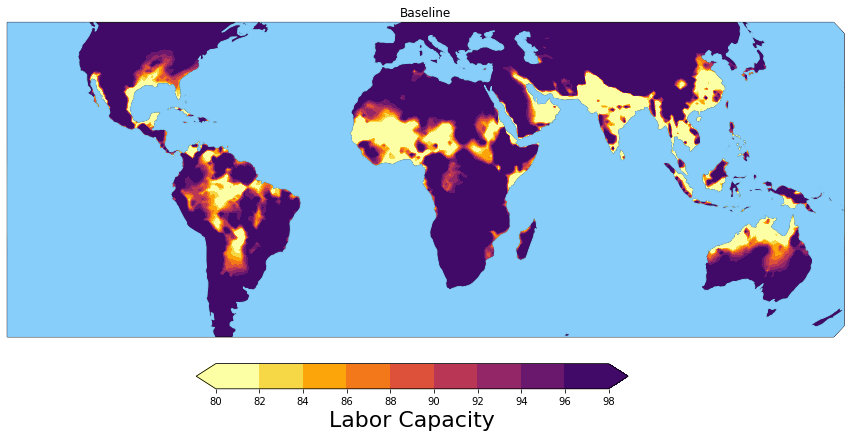

In [27]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(figsize=(15,7),subplot_kw={'projection':crs})
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
levels = np.arange(80,100,2)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,1,0.1))

im = lf.contour(ds_base,'Baseline',ax,levels=levels,cmap=None,colors=colors,over=None,crop=True)

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.125, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)

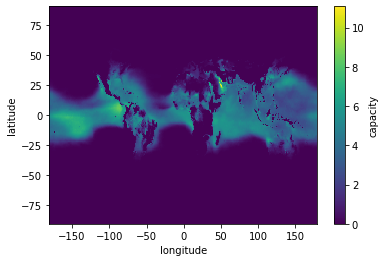

In [29]:
ds_hist_dev.plot()